# 03: Models and Analysis

In this notebook we'll try numerous models, running each selected model multiple times and storing each set of best parameters and scores to assess for possible use as our final model to solve our business problem.

*Please note: In a final portfolio version of this notebook, the modeling process would be simplified perhaps even by running each model only once over similar parameters. For my own edification, each pipeline/gridsearch/model has been run separately several times to give me more transparency into how tuning parameters affect the resulting model and scores.*

This notebook contains the following sections:
* Section 1: [Data Import, Baseline Score, Train/Test/Split](#data)
* Section 2: [Logistic Regression](#logistic)
* Section 3: [Random Forest Classifier](#forest)
* Section 4: [Gaussian Naive Bayes](#bayes)
* Section 5: [Support Vector Machine Classifier](#svm)
* Section 6: [Selected Model and Analysis (Logistic Regression)](#final)

After importing and separating our data into training and testing sets, each model will be constructed utilizing the same framework:
* A pipeline will be created that will contain:
    * What vectorizer will be used to vectorize our text data (may include additional transformers as well).
    * What model will be fitted on our vectorized text data in order to make class predictions for each row of vectorized text data.
* A parameter dictionary will be created to define the vectorizer and model parameters to be tested
* The pipeline and parameter dictionary will be passed into a grid search that will test every set of passed parameters for the transformer(s) and model across a number of subsections of our data (in our case 5), cross-validating and scoring each iteration. Based on the scoring, a vectorizer/model built with the best set of parameter (based on the ranges we specified in our dictionary) will be created.
* We'll then fit training data to the model and score both our training and test data to evaluate the model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.base import TransformerMixin

plt.style.use('fivethirtyeight')

## <a name="data"></a>Section 1: Data Import, Baseline Score, Train/Test/Split

### Data Import

In [3]:
df = pd.read_csv('./data/political_subreddit_clean.csv')

In [4]:
df.shape

(8828, 6)

### Baseline Score

In [5]:
df['subreddit'].value_counts(normalize=True)

0    0.338355
1    0.338015
2    0.323629
Name: subreddit, dtype: float64

The majority class for our data is the Republican subreddit with ~33.84%, so that will be our baseline accuracy score to beat.

### Train/Test/Split

For the purpose of these initial model, we will using the text data only to see how NLP alone performs classifying Reddit submissions for the three selected classes. 

In [6]:
# create our independent variable (will be transformed)
X = df['all_text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, stratify=y, train_size=0.7)

## <a name="logistic"></a>Section 2: Logistic Regression

For each model, a dataframe was created to track the results from each model. The commented out sections are there to keep from mistakenly resetting the dictionaries while multiple tests were being run.

In [15]:
# with thanks to Patrick in lesson 6.03 -- commented out to avoid running multiple times
# model_params = {}
# count = 0

In [101]:
# commented out parameters were likely used in different runs of the model

# instantiate pipeline
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=5000))
])

# parameters for GridSearch
params = {
    'cv__max_features': [500, 700, 900, 1000],
    'cv__stop_words': ['english'],
    'cv__ngram_range': [(1,2), (1,3)],
    'lr__penalty' : ['l1', 'l2'],
    'lr__solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'lr__C' : np.linspace(1, 10, 10)
}

# GridSearch over pipeline with given grid of parameters.
gs_cv = GridSearchCV(pipe_cv, params, cv=5, verbose=1, n_jobs=4)

# Fit model.
gs_cv.fit(X_train, y_train)

count += 1

gs_cv.best_params_['score'] = gs_cv.best_score_
gs_cv.best_params_['train_score'] = round(gs_cv.score(X_train, y_train), 4)
gs_cv.best_params_['test_score'] = round(gs_cv.score(X_test, y_test), 4)
model_params[f'model_{count}'] = gs_cv.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')

model_df.sort_index(inplace=True)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 21.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 36.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 59.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 95.6min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 161.0min
[Parallel(n_jobs=4)]: Done 4000 out of 4000 | elapsed: 227.0min finished


In [105]:
model_df

,cv__max_features,cv__ngram_range,cv__stop_words,lr__C,lr__penalty,score,train_score,test_score,lr__solver
model_1,500.0,"(1, 2)",english,1.0,l2,0.525002,0.6116,0.5236,saga
model_2,700.0,"(1, 2)",english,1.0,l1,0.534228,0.6399,0.5402,saga
model_3,800.0,"(1, 2)",english,NaN,l1,0.539083,0.6467,0.5459,liblinear
model_4,900.0,"(1, 2)",english,NaN,l1,0.539732,0.6564,0.5478,liblinear
model_5,NaN,"(1, 2)",english,NaN,l2,0.559962,0.9686,0.5851,liblinear
model_6,2000.0,"(1, 2)",english,NaN,l1,0.545235,0.7171,0.5613,liblinear
model_7,1000.0,"(1, 2)",english,NaN,l1,0.541027,0.6639,0.5481,liblinear
model_8,1000.0,"(1, 2)",english,1.0,l1,0.540703,0.6639,0.5478,liblinear


For logistic regression, Model_3 is the winner here with one of the better crossval accuracy scores and one of the smaller differences between the training and testing accuracy scores. The model is still overfit and with some additional tweaking we would hopefully be able to bring to training and testing scores closer together to make sure the model would have the best chance to generalize to unseen data.

The following line is commented out to keep from running except by choice. You can view the above as a csv file [here]('./data/model_results/Logistic_results.csv).

In [106]:
# model_df.to_csv('./Logistic_results.csv', index=False)

## <a name="forest"></a>Section 3: Random Forest Classifier

For each model, a dataframe was created to track the results from each model. The commented out sections are there to keep from mistakenly resetting the dictionaries while multiple tests were being run.

In [47]:
# model2_params = {}
# count2 = 0

In [63]:
# commented out parameters were likely used in different runs of the model

# instantiate pipeline
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('rf', RandomForestClassifier())
])

# parameters for GridSearch
params = {
    'cv__max_features': [900, 1000, 1200],
    'cv__stop_words': ['english'], # None
    'cv__ngram_range': [(1,2)],
    'cv__max_df': [1.0, 0.75, 0.5, 0.25],
    'cv__min_df' : [1, 0.01, 0.05, 0.1],
    'tf__use_idf' : [True, False],
    'rf__n_estimators' : [100, 125, 150],
    'rf__max_features' : ['log2'],
    'rf__max_depth' : [3, 5, 7],
    #'rf__ccp_alpha' : [0, 0.0001, 0.01, 0.1]
}

# GridSearch over pipeline with given grid of parameters.
gs_cv = GridSearchCV(pipe_cv, params, cv=5, verbose=1, n_jobs=4, scoring='accuracy')

# Fit model.
gs_cv.fit(X_train, y_train)

count2 += 1

gs_cv.best_params_['score'] = gs_cv.best_score_
gs_cv.best_params_['train_score'] = round(gs_cv.score(X_train, y_train), 4)
gs_cv.best_params_['test_score'] = round(gs_cv.score(X_test, y_test), 4)
model2_params[f'model_{count2}'] = gs_cv.best_params_

model2_df = pd.DataFrame.from_dict(model2_params, orient='index')

model2_df.sort_index(inplace=True)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done 4320 out of 4320 | elapsed: 11.1min finished


In [64]:
model2_df

,cv__max_features,cv__ngram_range,cv__stop_words,rf__ccp_alpha,rf__max_depth,rf__max_features,rf__n_estimators,tf__use_idf,score,train_score,test_score,cv__max_df,cv__min_df
model_1,900,"(1, 2)",english,0.0,5,log2,125,False,0.493284,0.5187,0.4689,NaN,NaN
model_2,1000,"(1, 2)",english,NaN,5,log2,125,True,0.490047,0.5308,0.4753,1.0,1.0
model_3,1200,"(1, 2)",english,NaN,7,log2,150,False,0.499110,0.5706,0.4923,0.5,1.0


For the Random Forest Classifier, Model_1 is the winner here for me with one of the better crossval accuracy scores and the smallest differences between the training and testing accuracy scores. The model is still overfit and with some additional tweaking we would hopefully be able to bring to training and testing scores closer together to make sure the model would have the best chance to generalize to unseen data.

The following line is commented out to keep from running except by choice. You can view the above as a csv file [here]('./data/model_results/RandomForest_results.csv).

In [81]:
# model2_df.to_csv('./RandomForest_results.csv', index=False)

## <a name="bayes"></a>Section 4: Gaussian Naive Bayes

For each model, a dataframe was created to track the results from each model. The commented out sections are there to keep from mistakenly resetting the dictionaries while multiple tests were being run.

In [68]:
# model3_params = {}
# count3 = 0

In [71]:
# thanks to Noah for including this as part of the lab review
# adapted from https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [86]:
# commented out parameters were likely used in different runs of the model

# instantiate pipeline
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ("_", DenseTransformer()),
    ('gnb', GaussianNB())
])

# set hyperparameters
params = {'tfid__max_features': [500, 600, 700], 
          'tfid__ngram_range'  : [(1,2), (1,3)], 
          'tfid__stop_words'   : ['english', None], 
          'tfid__max_df': [1.0, 0.75, 0.5, 0.25], 
          'tfid__min_df' : [1, 0.01, 0.05, 0.1]
         }

gs_cv = GridSearchCV(pipe, param_grid = params, cv = 5, 
                     verbose=1, n_jobs=4,scoring = 'accuracy')

# fit model
gs_cv.fit(X_train, y_train)

count3 += 1

gs_cv.best_params_['score'] = gs_cv.best_score_
gs_cv.best_params_['train_score'] = round(gs_cv.score(X_train, y_train), 4)
gs_cv.best_params_['test_score'] = round(gs_cv.score(X_test, y_test), 4)
model3_params[f'model_{count3}'] = gs_cv.best_params_

model3_df = pd.DataFrame.from_dict(model3_params, orient='index')

model3_df.sort_index(inplace=True)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:  2.1min finished


In [89]:
model3_df

,tfid__max_features,tfid__ngram_range,tfid__stop_words,score,train_score,test_score,tfid__max_df,tfid__min_df
model_1,500,"(1, 3)",english,0.476612,0.5616,0.4949,NaN,NaN
model_2,500,"(1, 3)",english,0.476612,0.5616,0.4949,1.00,1.0
model_3,900,"(1, 2)",None,0.481790,0.5863,0.4923,NaN,NaN
model_4,900,"(1, 2)",None,0.481790,0.5863,0.4923,1.00,1.0
model_5,500,"(1, 2)",None,0.480172,0.5661,0.4991,0.25,1.0
model_6,600,"(1, 2)",None,0.487456,0.5713,0.4885,1.00,1.0


For Gaussian Naive Bayes, Model_5 is the winner here for me with one of the better crossval accuracy scores and the smallest differences between the training and testing accuracy scores. The model is still overfit and with some additional tweaking we would hopefully be able to bring to training and testing scores closer together. Additionally, the fact that the test score is exceeding the crossval score consistently makes me wonder if the random state used to train/test/split our data may have affected the accuracy of using this with additional data. More testing is required. 

The following line is commented out to keep from running except by choice. You can view the above as a csv file [here]('./data/model_results/GaussianNB_results.csv).

In [88]:
# model3_df.to_csv('./GaussianNB_results.csv', index=False)

## <a name="svm"></a>Section 5: Support Vector Machine Classifier

For each model, a dataframe was created to track the results from each model. The commented out sections are there to keep from mistakenly resetting the dictionaries while multiple tests were being run.

In [91]:
# model4_params = {}
# count4 = 0

In [95]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
#     ("_", DenseTransformer()),
    ('svc', SVC())
])

# set hyperparameters
params = {'tfid__max_features': [500, 600, 700], 
          'tfid__ngram_range'  : [(1,2), (1,3)], 
          'tfid__stop_words'   : ['english', None], 
#           'tfid__max_df': [1.0, 0.75, 0.5, 0.25], 
#           'tfid__min_df' : [1, 0.01, 0.05, 0.1],
          'svc__C': np.linspace(.0001, 10, 10),
          'svc__kernel' : ['rbf', 'poly'], # 'linear', 'poly', 'rbf', 'sigmoid' 
          'svc__gamma' : ['scale', 'auto'], 
          'svc__degree': [1,2,3,4]
         }

gs_cv = GridSearchCV(pipe, param_grid = params, cv = 5, 
                     verbose=1, n_jobs=4,scoring = 'accuracy')

# fit model
gs_cv.fit(X_train, y_train)

count4 += 1

gs_cv.best_params_['score'] = gs_cv.best_score_
gs_cv.best_params_['train_score'] = round(gs_cv.score(X_train, y_train), 4)
gs_cv.best_params_['test_score'] = round(gs_cv.score(X_test, y_test), 4)
model4_params[f'model_{count4}'] = gs_cv.best_params_

model4_df = pd.DataFrame.from_dict(model4_params, orient='index')

model4_df.sort_index(inplace=True)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  9.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 14.9min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 22.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 30.5min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 40.6min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 52.1min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 65.4min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 79.5min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 94.1min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 110.4min
[Parallel(n_jobs=4)]: Done 9600 out of 9600 | elapsed: 124.7min finished


In [102]:
model4_df

,svc__C,svc__degree,svc__gamma,svc__kernel,tfid__max_features,tfid__ngram_range,tfid__stop_words,score,train_score,test_score
model_1,1.1112,1,scale,rbf,600,"(1, 3)",english,0.536169,0.8168,0.5459
model_2,1.1112,1,scale,rbf,600,"(1, 3)",english,0.536169,0.8168,0.5459


For SVM, both models ended up using the same parameters resulting in the same scores. The models are extremely overfir with training scores well above the crossval and test score. A lot more tweaking would be needed: reducing the number of features increasing the regularization by decreasing the C value for the SVC.

The following line is commented out to keep from running except by choice. You can view the above as a csv file [here]('./data/model_results/SVM_results.csv).

In [97]:
# model4_df.to_csv('./SVM_results.csv', index=False)

## <a name="final"></a>Section 6: Selected Model and Analysis (Logistic Regression)

After reviewing the performance of the various models, let's go with the Logistic Regression model.

While still overfit, it had...
* The best crossval accuracy score of the model "winners"
* The best testing data accuracy score of the model "winners'
* An improvement over our baseline score by 20.8% (33.8% baseline vs 54.6% test data)

Additionally, logistic regression will give us...
* Easy interpretability -- especially if we use one-versus-the-rest for multinomial classification
    * Coefficients will be interpretable as the log-odds compared to all other classes, holding all else constant. 

So let's build the model using the parameters from our grid search.

In [15]:
# using parameters from selected model from GridSearch
ovr_cv = CountVectorizer(max_features=800, ngram_range=(1,2), stop_words='english')

X_train_ovr = ovr_cv.fit_transform(X_train)
X_test_ovr = ovr_cv.transform(X_test)

# using parameters from selected model from GridSearch
ovr_lr = LogisticRegression(multi_class='ovr', solver='liblinear', penalty='l1')

ovr_lr.fit(X_train_ovr, y_train)

print(f'Training accuracy score: {round(ovr_lr.score(X_train_ovr, y_train), 3)}')
print(f'Testing accuracy score: {round(ovr_lr.score(X_test_ovr, y_test), 3)}')

Training accuracy score: 0.647
Testing accuracy score: 0.546


Our logistic model is rebuilt and the training and testing scores are recalculated and match.

Let's look at where our predictions went right (and where they went wrong) using a confusion matrix and classification report for the predictions on our test data.

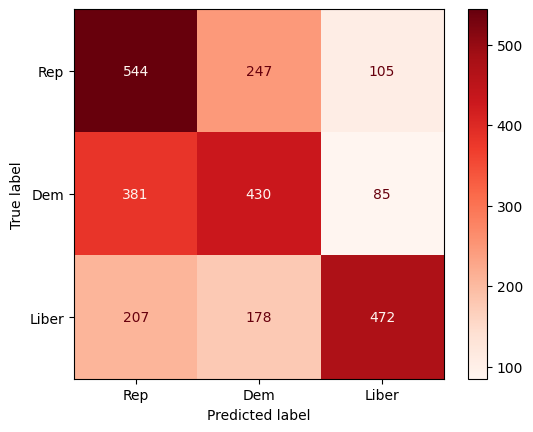

In [16]:
plt.style.use('default')
plot_confusion_matrix(ovr_lr, X_test_ovr, y_test, cmap='Reds', display_labels=['Rep', 'Dem', 'Liber']);

In [17]:
print(classification_report(y_test, ovr_lr.predict(X_test_ovr)))

              precision    recall  f1-score   support

           0       0.48      0.61      0.54       896
           1       0.50      0.48      0.49       896
           2       0.71      0.55      0.62       857

    accuracy                           0.55      2649
   macro avg       0.57      0.55      0.55      2649
weighted avg       0.56      0.55      0.55      2649



For the 2,649 predictions made on our test data, we had a strong positive predictive rate for Libertarians (71%) and best true positive rate for Republicans (61%).

What's most interesting is where we missed. Most notably the Democrats we predicted to be Republicans. If we dug a little deeper into understanding why we missed here, the corrections would likely have a ripple effect on the entire matrix. In our next iteration, perhaps the creation of unique set of stop words would be the next step.

Let's look at the coefficients of our regression to identify the vectorized features with the strongest and weakest odds on the likelihood of that feature to predict a given class in relation to all other classes.

In [19]:
# creating dataframes for each classes exponentalized log-odd coefficients for interpretation
ovr_lr_rep_exp_Beta = pd.DataFrame(np.exp(ovr_lr.coef_[0]), columns = ['Coefficients'], index = ovr_cv.get_feature_names()).sort_values(by='Coefficients', ascending=False)
ovr_lr_dem_exp_Beta = pd.DataFrame(np.exp(ovr_lr.coef_[1]), columns = ['Coefficients'], index = ovr_cv.get_feature_names()).sort_values(by='Coefficients', ascending=False)
ovr_lr_lib_exp_Beta = pd.DataFrame(np.exp(ovr_lr.coef_[2]), columns = ['Coefficients'], index = ovr_cv.get_feature_names()).sort_values(by='Coefficients', ascending=False)

In [20]:
# creating dataframes retaining the log-odds
ovr_lr_rep_logodds = pd.DataFrame(ovr_lr.coef_[0], columns = ['Coefficients'], index = ovr_cv.get_feature_names()).sort_values(by='Coefficients', ascending=False)
ovr_lr_dem_logodds = pd.DataFrame(ovr_lr.coef_[1], columns = ['Coefficients'], index = ovr_cv.get_feature_names()).sort_values(by='Coefficients', ascending=False)
ovr_lr_lib_logodds = pd.DataFrame(ovr_lr.coef_[2], columns = ['Coefficients'], index = ovr_cv.get_feature_names()).sort_values(by='Coefficients', ascending=False)

In [21]:
# top and bottom 10 features by log-odds 
rep_top_bottom = pd.concat([ovr_lr_rep_logodds[:10], ovr_lr_rep_logodds[-10:]], axis=0)
dem_top_bottom = pd.concat([ovr_lr_dem_logodds[:10], ovr_lr_dem_logodds[-10:]], axis=0)
lib_top_bottom = pd.concat([ovr_lr_lib_logodds[:10], ovr_lr_lib_logodds[-10:]], axis=0)

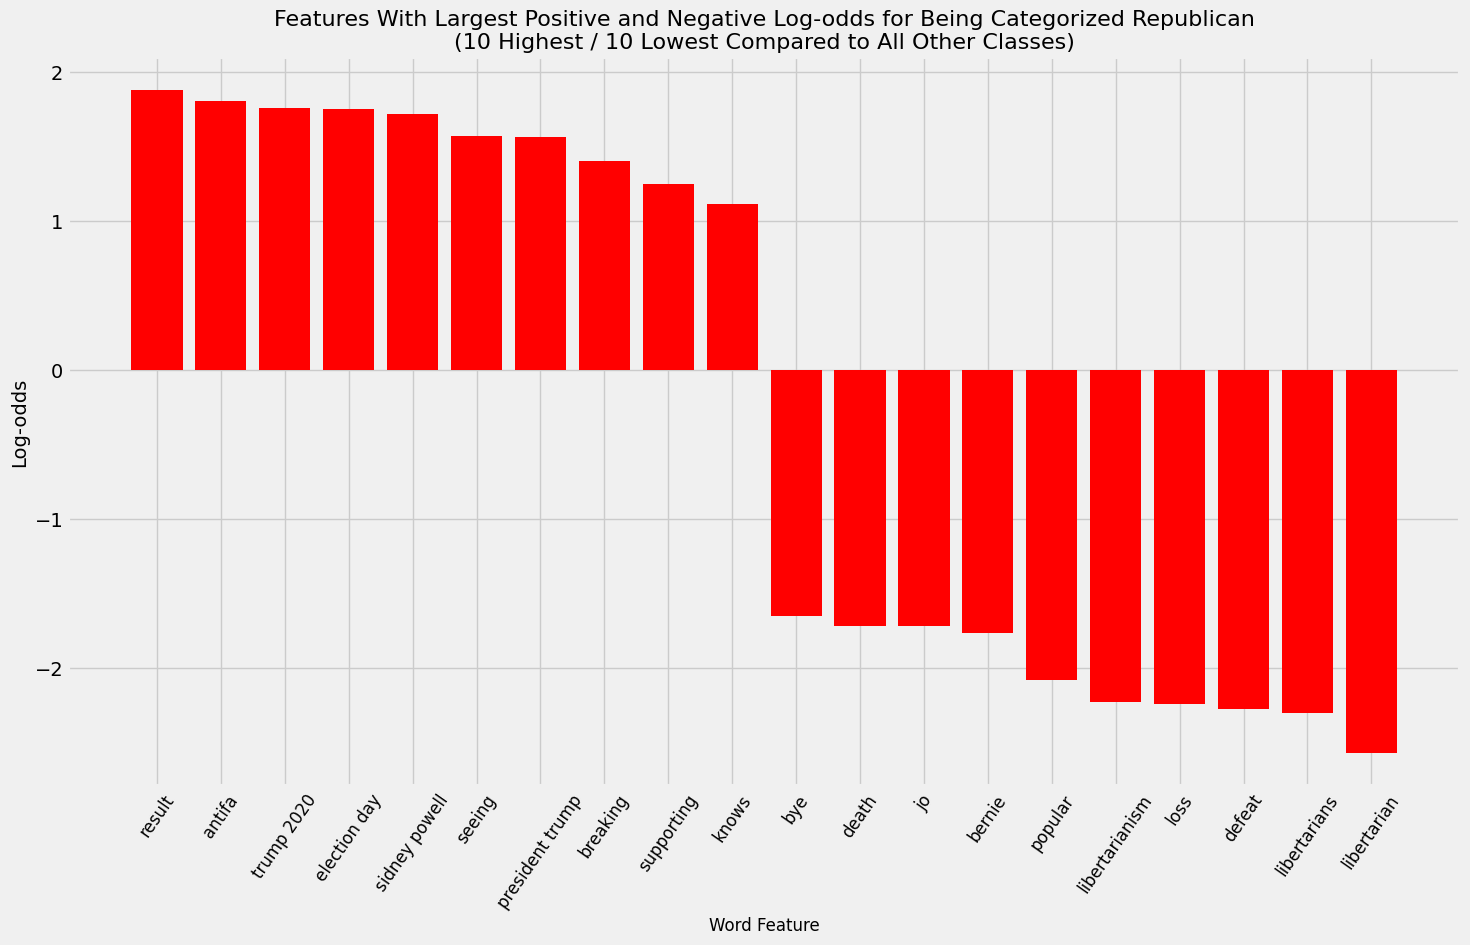

In [22]:
# plotting top and bottom features determined by log-odds
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,9))
plt.bar(rep_top_bottom.index, rep_top_bottom['Coefficients'], color='red')
plt.title('Features With Largest Positive and Negative Log-odds for Being Categorized Republican\n(10 Highest / 10 Lowest Compared to All Other Classes)', size=16)
plt.xlabel('Word Feature', size=12)
plt.ylabel('Log-odds', size=14)
plt.xticks(size=12, rotation=55);

Of the top 800 unigram and bigram features the model created, the above represents the 10 with the strongest and the 10 with the weakest odds for an occurrence of the feature to be in a Reddit submission categorized as Republican. Graphing these values as the log-odds make their postive and negative odds impact clearer when graphing them side by side.

In the top 10, there are no major surprises here. Since these submissions surround the election and it's ongoing reverberations, the specific references to the election, Trump, his lawyer, and "antifa" are expected. It's the bottom 10 that are (perhaps) more interesting. The negative log-odds of the words "bye", "popular", "loss", and "defeat" are very telling as their appearance would hurt the likelihood that the post would be categorized as Republican.

The Libertarian-related features as well as "bernie" would be added to stop words and tested in the next iteration.


Next we'll look at a sample interpretation of the features with the highest and lowest log-odds. 

In [23]:
# pulling the top and bottom features
rep_top_bottom_exp_Beta = pd.concat([ovr_lr_rep_exp_Beta[:1], ovr_lr_rep_exp_Beta[-1:]], axis=0)

rep_top_bottom_exp_Beta

,Coefficients
result,6.529069
libertarian,0.076288


Sample interpretation of the exponentiated log-odd coefficients for top and bottom feature:

* For every single occurrence  of the word ‘result’, the submission is 6.53x as likely to be in the Republican subreddit compared to all other classes, holding all else constant.
* For every single occurrence  of the word ‘libertarian’, the submission is 0.08x as likely to be in the Republican subreddit compared to all other classes, holding all else constant.


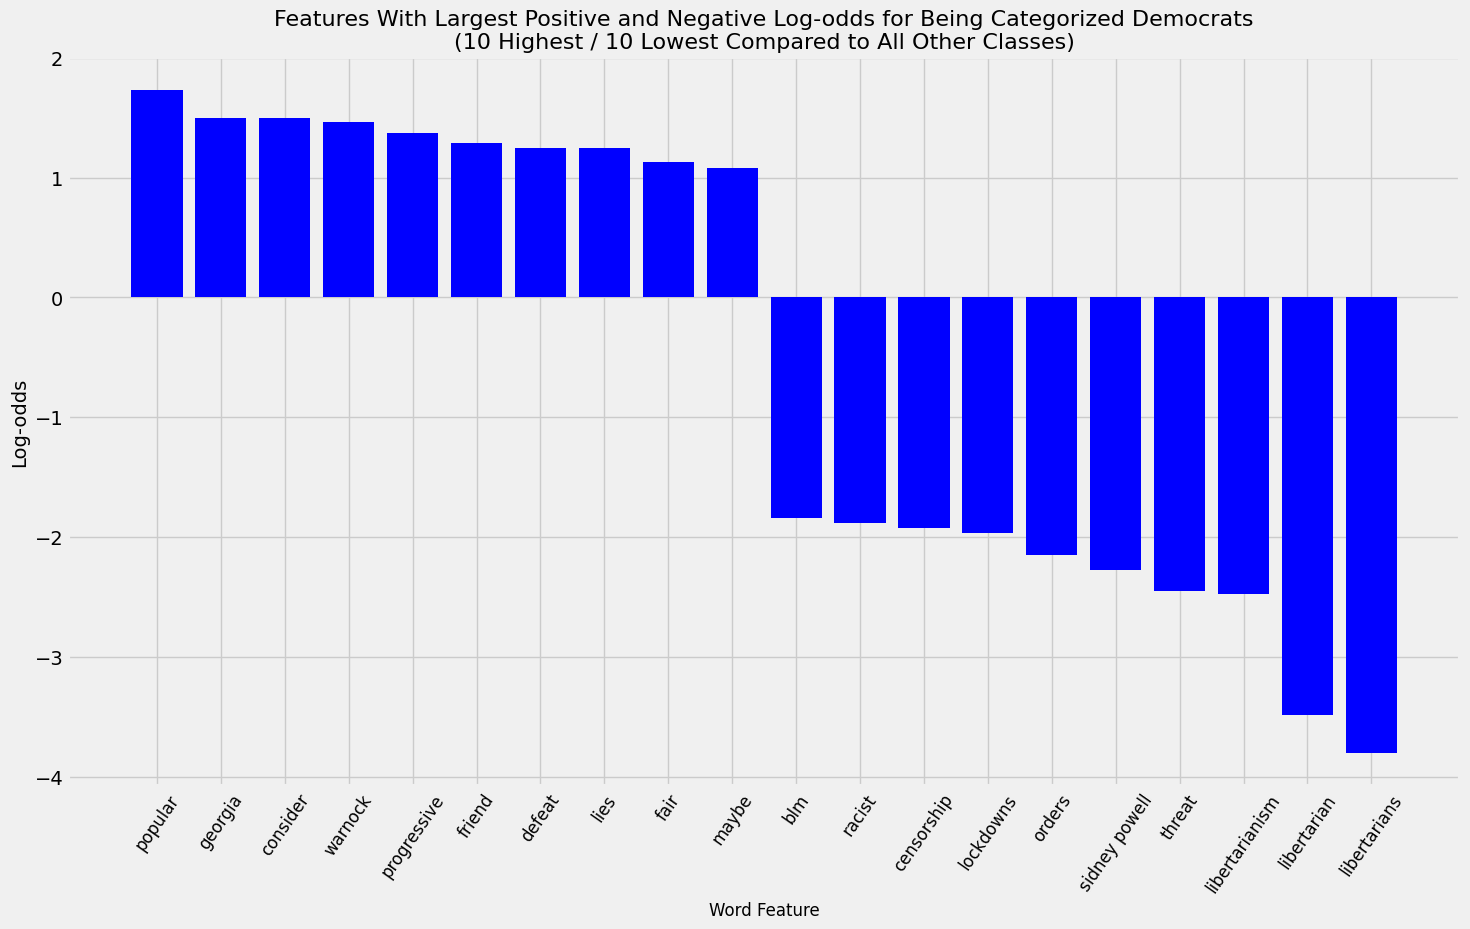

In [24]:
plt.figure(figsize=(16,9))
plt.bar(dem_top_bottom.index, dem_top_bottom['Coefficients'], color='blue')
plt.title('Features With Largest Positive and Negative Log-odds for Being Categorized Democrats\n(10 Highest / 10 Lowest Compared to All Other Classes)', size=16)
plt.xlabel('Word Feature', size=12)
plt.ylabel('Log-odds', size=14)
plt.xticks(size=12, rotation=55);

Of the top 800 unigram and bigram features the model created, the above represents the 10 with the strongest and the 10 with the weakest odds for an occurrence of the feature to be in a Reddit submission categorized as Democrat.

In the top 10, again no big surprises as most of the features are related to the election (winning of the "popular" vote), the recount in Georgia and the upcoming runoff (with US Senate candidate Warnock). The feature 'maybe' in the top 10 is interesting and we should look to see it should be here. We would want to test how the model functions without it.

It's the bottom 10 that again are more interesting. The negative log-odds of the words "blm", "racist", "censorship", "lockdowns", "orders", and "threat" would seem to indicate that Democrats are not mentioning these movements, issues, or negative components of COVID or the election (perhaps). It would be interesting to do sentiment analysis these submissions and see if they have any predictive power.

The Libertarian-related features as well as "Sidney Powell" would be added to stop words and tested in the next iteration.


Next we'll look at a sample interpretation of the features with the highest and lowest log-odds. 

In [25]:
dem_top_bottom_exp_Beta = pd.concat([ovr_lr_dem_exp_Beta[:1], ovr_lr_dem_exp_Beta[-1:]], axis=0)

dem_top_bottom_exp_Beta

,Coefficients
popular,5.644077
libertarians,0.022405


Sample interpretation of the exponentiated log-odd coefficients for top and bottom feature:

* For every single occurrence  of the word ‘popular’, the submission is 5.65x as likely to be in the Democrats subreddit compared to all other classes, holding all else constant.
* For every single occurrence  of the word ‘libertarians’, the submission is 0.02x as likely to be in the Democrats subreddit compared to all other classes, holding all else constant.


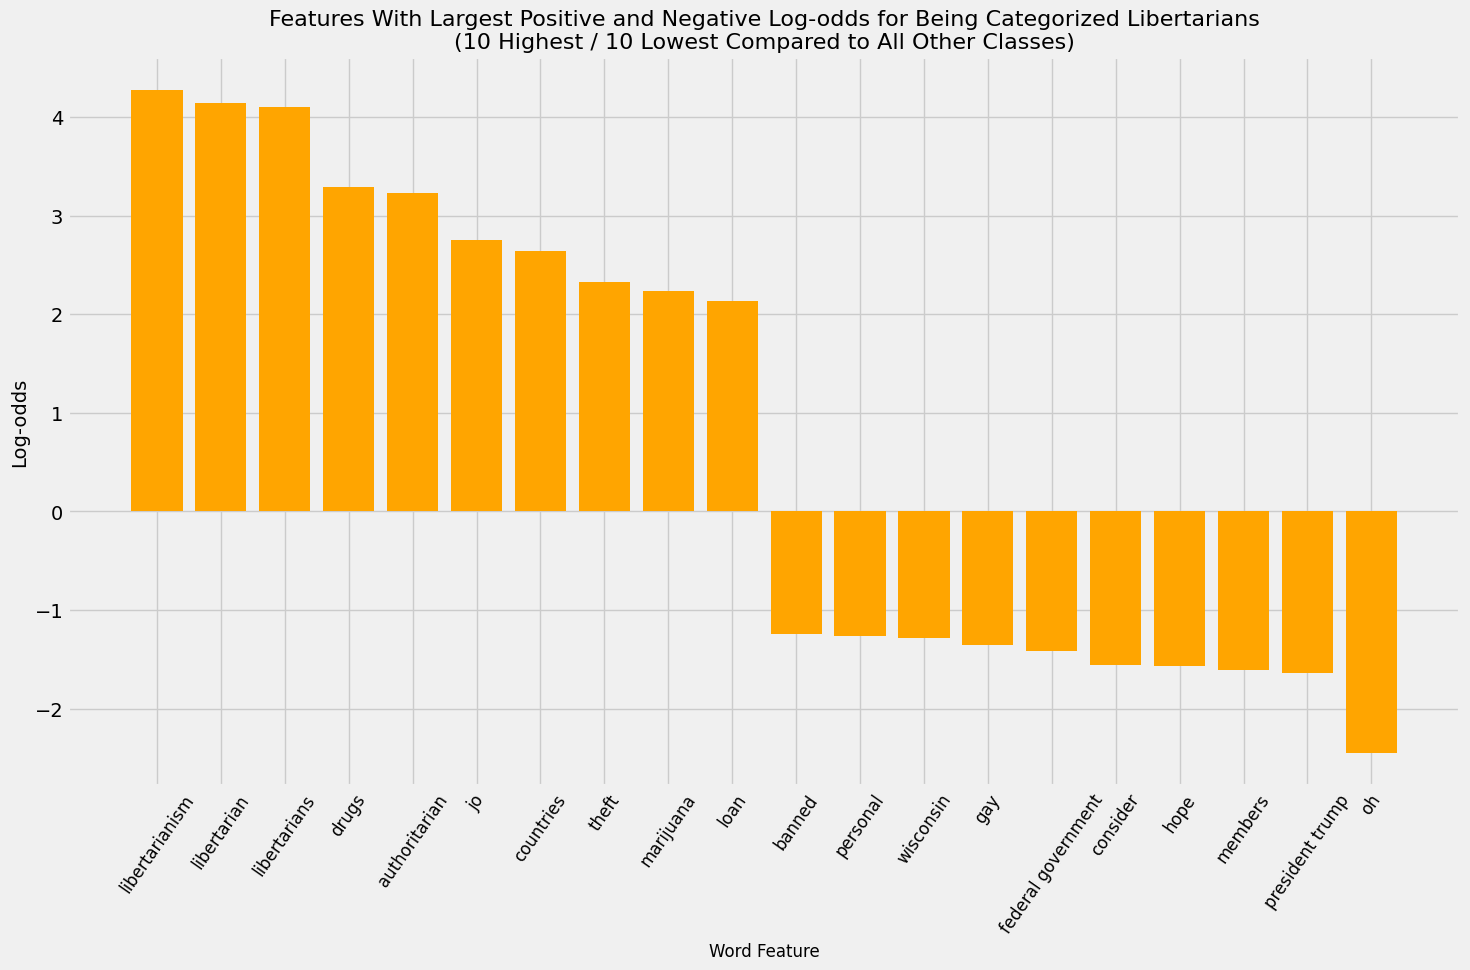

In [26]:
plt.figure(figsize=(16,9))
plt.bar(lib_top_bottom.index, lib_top_bottom['Coefficients'], color='orange')
plt.title('Features With Largest Positive and Negative Log-odds for Being Categorized Libertarians\n(10 Highest / 10 Lowest Compared to All Other Classes)', size=16)
plt.xlabel('Word Feature', size=12)
plt.ylabel('Log-odds', size=14)
plt.xticks(size=12, rotation=55);

Of the top 800 unigram and bigram features the model created, the above represents the 10 with the strongest and the 10 with the weakest odds for an occurrence of the feature to be in a Reddit submission categorized as Libertarian.

In the top 10, the Libertarians are clearly not as preoccupied with the election as the other two subreddits with the only possible mention being "jo" a shortened version of "Joe". Also, note that "President Trump" is in the bottom two.

Libertarian's focus on identifying their political ideology as the top three features is notable as that self identification as a predictor is absent in the other two subreddits.

These predictors seem to center around issues "drugs", "marijuana", "authoritarian", and "federal government". It is interesting to note that "personal" has a negative log-odds.

Also, the bottom feature is "oh" that likely stands for Ohio, but we'll need to examine that in our next iteration.

The specific Libertarian-related features would be added to stop words and tested in the next iteration.

Next we'll look at a sample interpretation of the features with the highest and lowest log-odds. 

In [27]:
lib_top_bottom_exp_Beta = pd.concat([ovr_lr_lib_exp_Beta[:1], ovr_lr_lib_exp_Beta[-1:]], axis=0)

lib_top_bottom_exp_Beta

,Coefficients
libertarianism,71.672330
oh,0.086515


Sample interpretation of the exponentiated log-odd coefficients for top and bottom feature:

* For every single occurrence  of the word ‘libertarianism’, the submission is 71.66x as likely to be in the Libertarians subreddit compared to all other classes, holding all else constant.
* For every single occurrence  of the word ‘oh’, the submission is 0.09x as likely to be in the Libertarians subreddit compared to all other classes, holding all else constant.


Please see next steps in the Read Me for what is next for this project.